# TP BE Météo

## Chargement des librairies

cf readme

In [26]:
library(sf)
library(ggplot2)
library("rnaturalearth")
library("rnaturalearthdata")
library(dplyr)
library(glue)

pcolors = c("#FFBE0B", "#FF006E", "#8338EC", "#5A96FF", "#880D1E", "#4CC9F0")

## Chargement des données

In [27]:
# 31s à s'exécuter sur Stuart
data_full_dir = "../data/donnees-synop-essentielles-omm.csv"
# 9s à s'exécuter sur stuart
data_ext10_dir = "../data/donnees_extracted_10.csv"
data_ext10M_dir = "../data/donnees_extracted_metro_10.csv"

full_data <- read.csv(data_full_dir, 
            sep=";", # à toggle en fonction du fichier (',' pour les extracts, ';' pour l'originel)
            na.string=c("","null","NaN"),
            header=TRUE, 
            stringsAsFactors=TRUE)

## Fonction de dendogrammerie

In [28]:

auto_dendogram <- function(crit_data, nk){

    # distances
    distances <- dist(crit_data)
    # la distance par défaut est 'complete', ie maximale.
    # plot dendrogramme et sépare l'arbre
    cah_tree <- hclust(distances, method="ward.D")
    clusters <- cutree(cah_tree, k = nk, h = NULL)
    par(bg = 'white')
    options(repr.plot.width=16, repr.plot.height=10)
    plot(cah_tree, main = glue("Dendrogram with {nk} clusters"))
    rectlist = rect.hclust(cah_tree, k = nk, border = 2:(nk+1))

    # plot la hauteur en fonction du nombre de groupe
    # print(cah_tree$height)
    par(bg = 'white')
    plot(cah_tree$height, col='red', type='l')
    grid(col="gray")

    # plot les groupes en couleur sur une carte du monde
    options(repr.plot.width=18, repr.plot.height=12)
    worldmap <- ne_countries(scale = 'medium', type = 'map_units', returnclass = 'sf')

    i <- 1
    p <- ggplot()
    p <- p + geom_sf(data = worldmap, color = "black", fill = "#CAFFDA")
    for(v in rectlist){
        p <- p + geom_point(data = crit_data[rownames(crit_data) %in% names(v), ], 
                aes(x = Longitude, y = Latitude), color = pcolors[[i]], size = 3)
    i <- (i+1)%%length(pcolors)
    }
    p <- p + coord_sf() + theme_minimal()
    print(p)
}

## Critère : latitude et longitude

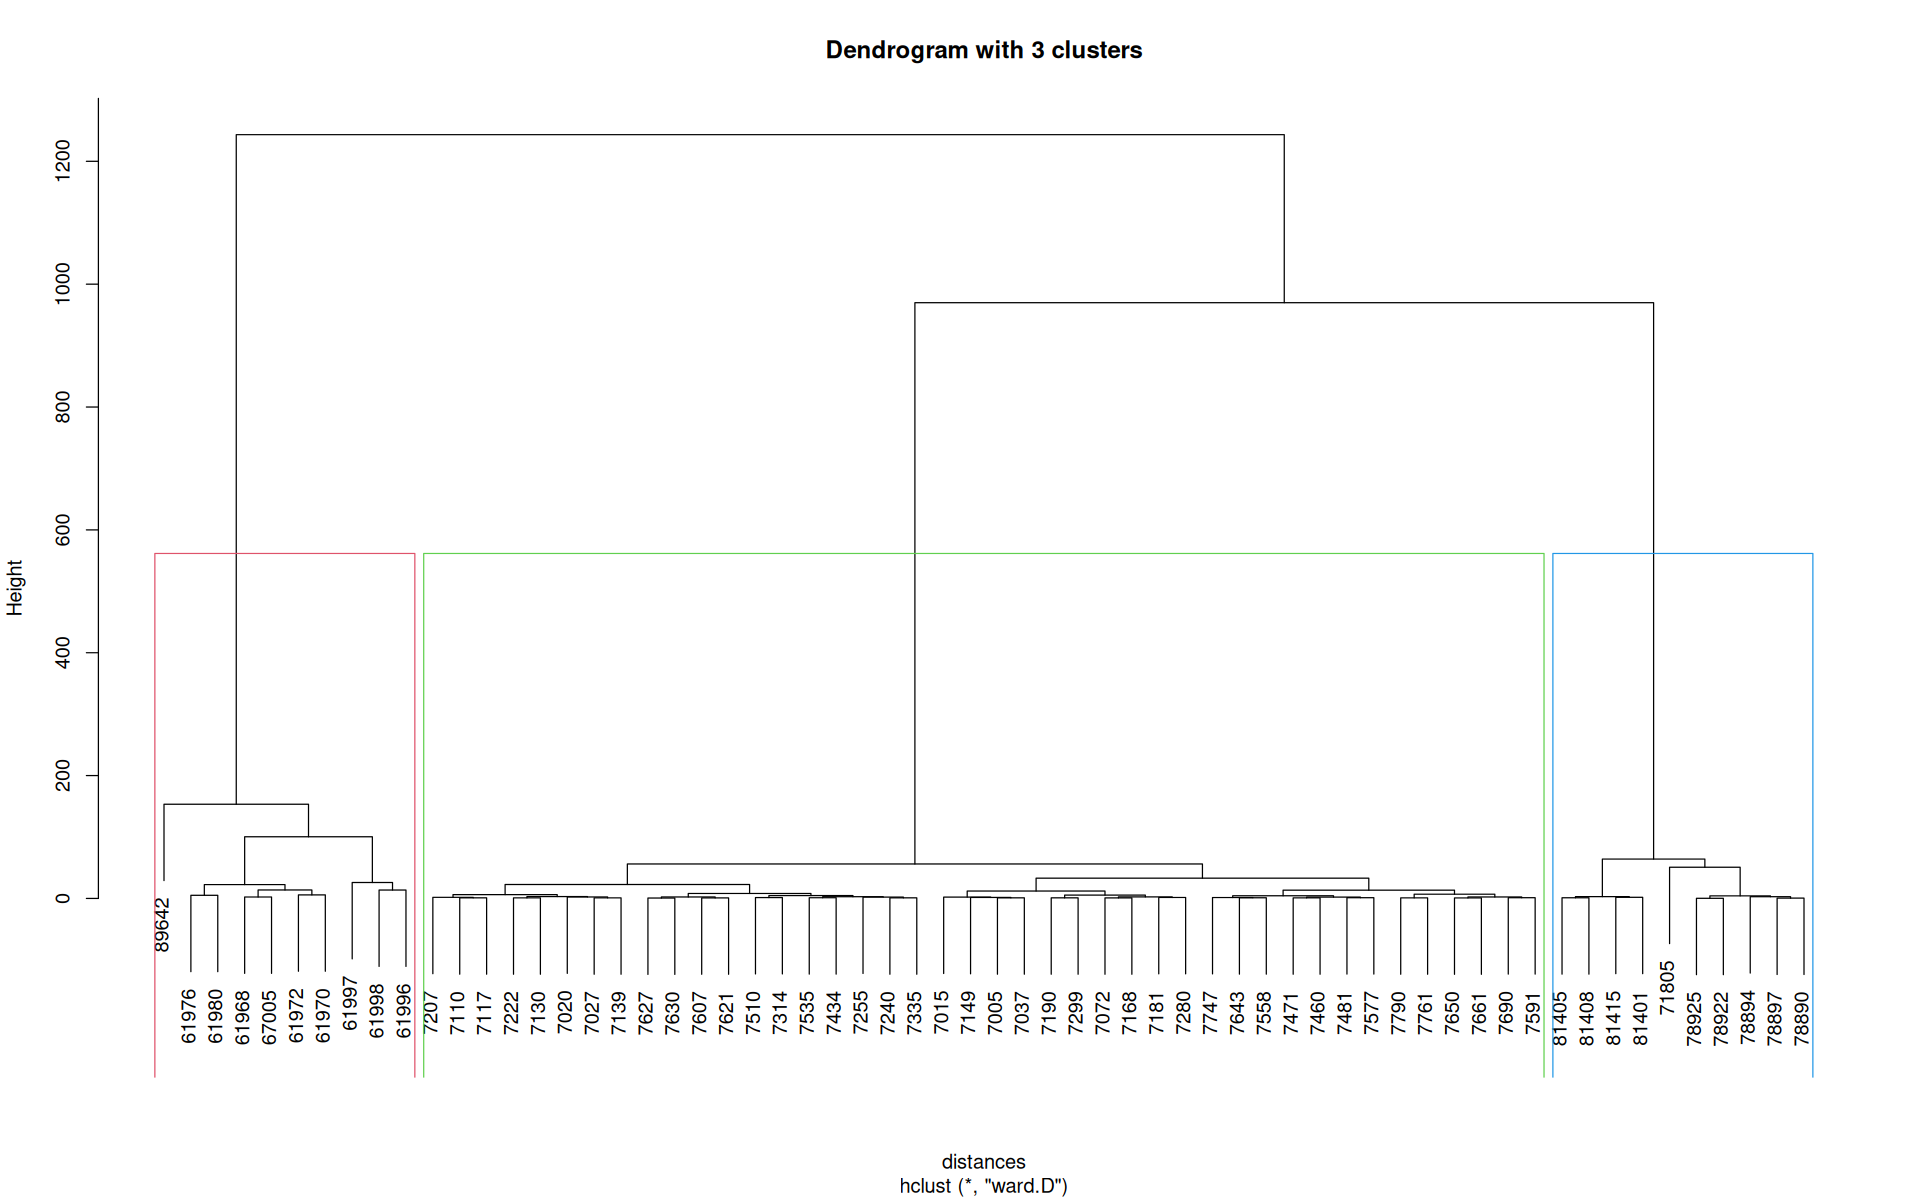

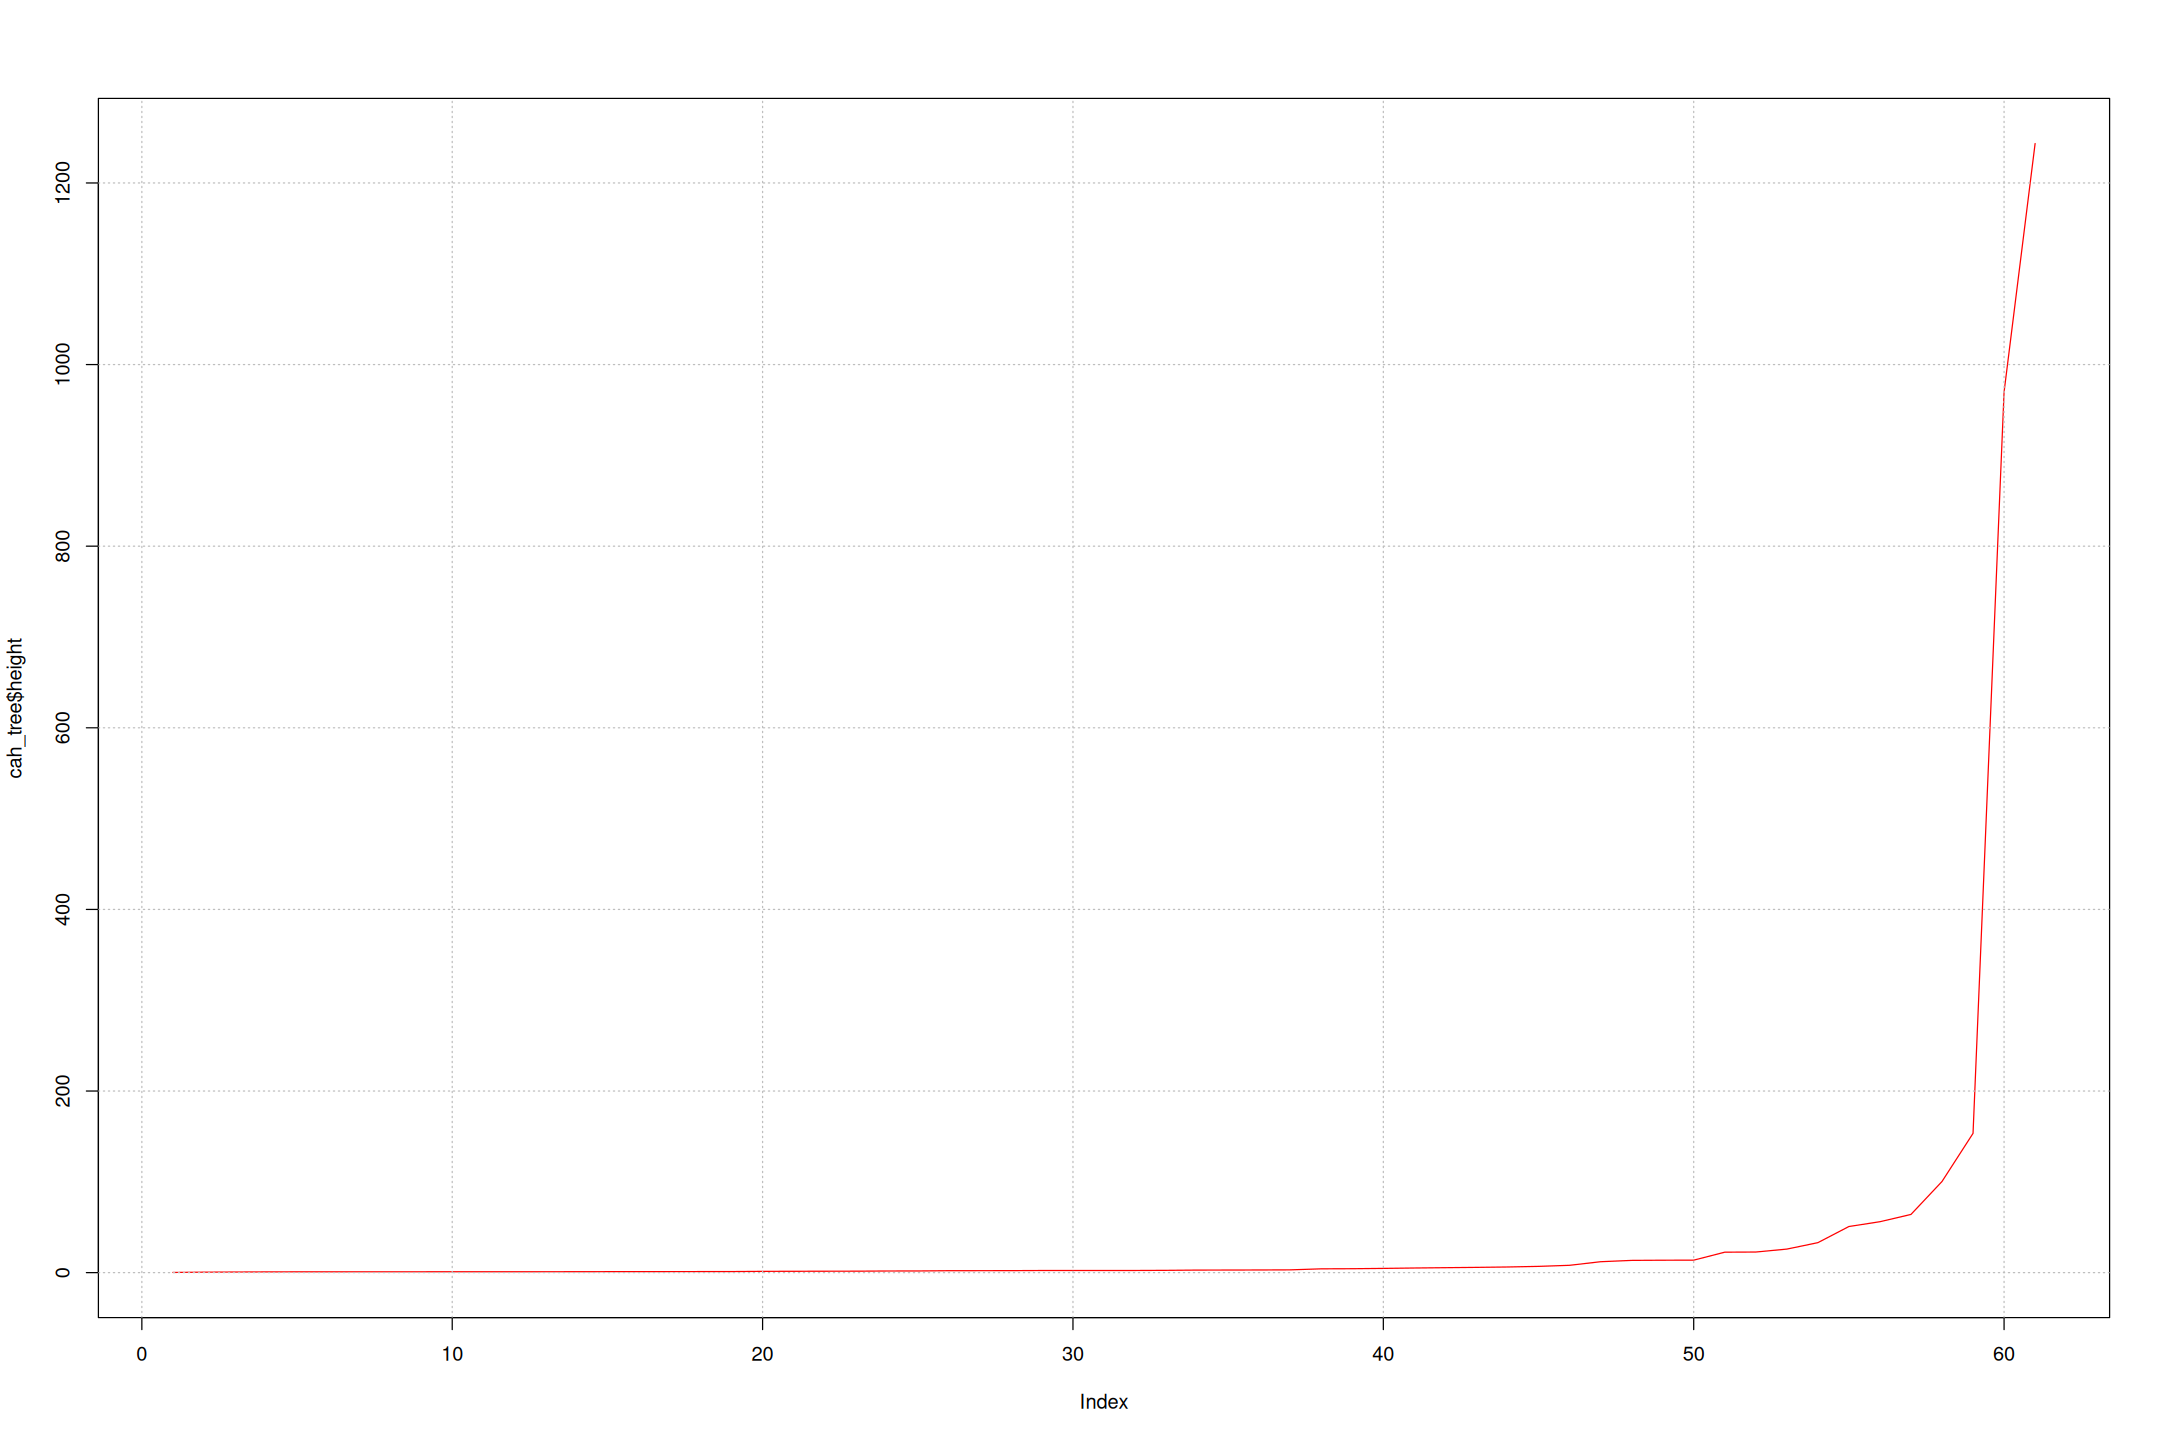

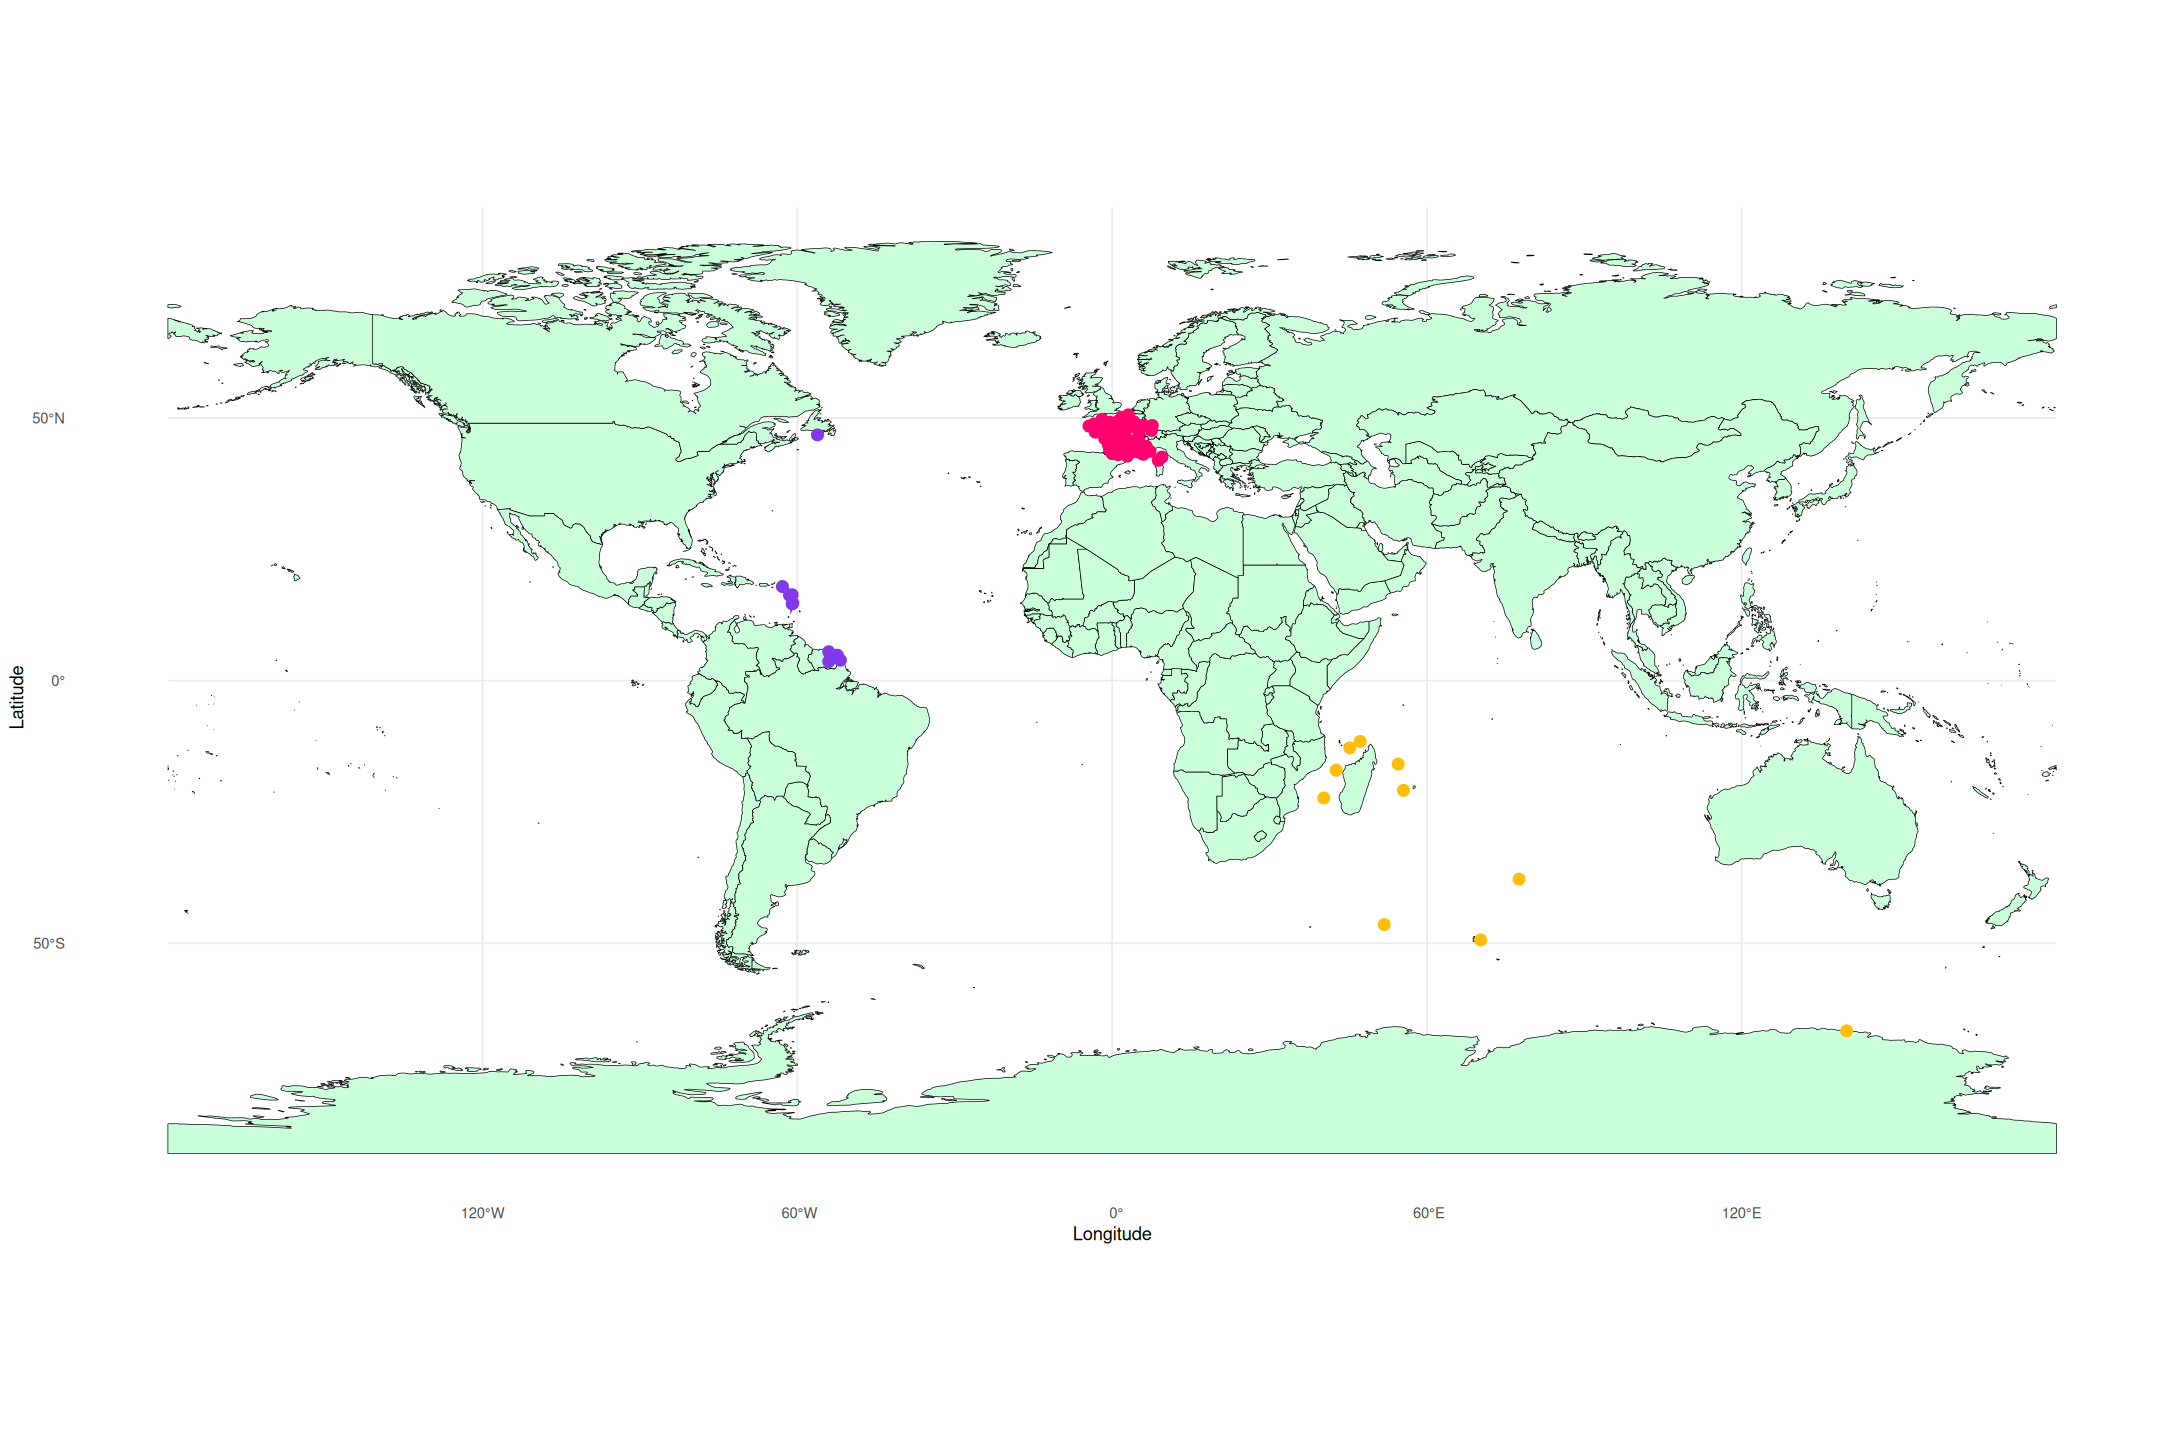

In [29]:
# extract latitudes and longitude
geo_data <- full_data[, c("ID.OMM.station", "Latitude", "Longitude")]
# make it unique
geo_data <- geo_data[!duplicated(geo_data["ID.OMM.station"]), ]

# replace names of rows by station id
row.names(geo_data) <- geo_data$ID.OMM.station
# and delete column
geo_data <- geo_data[, -which(names(geo_data) == "ID.OMM.station")]
# print(geo_data)

# display dendogram and map
auto_dendogram(geo_data, nk=3)

## Critère : Température

In [30]:

# extract two columns temperatures for each station
temperature_data <- full_data[, c("ID.OMM.station", "Température...C.", "Température...C.", "Latitude", "Longitude")]
colnames(temperature_data) = c("ID.OMM.station", "TempératureMin", "TempératureMax", "Latitude", "Longitude")

# group by station, and create all-time min. temperature and max. temperature
temp_alltime_data <- temperature_data %>%
  group_by(ID.OMM.station) %>%
  summarise(
    TempératureMin = min(TempératureMin, na.rm = TRUE),
    TempératureMax = max(TempératureMax, na.rm = TRUE),
    Latitude = min(Latitude, na.rm = TRUE),
    Longitude = min(Longitude, na.rm = TRUE),
    .groups = "drop"
  )
# change row names to station nameds
temp_alltime_data <- as.data.frame(temp_alltime_data)
row.names(temp_alltime_data) <- temp_alltime_data$ID.OMM.station
print(temp_alltime_data)



      ID.OMM.station TempératureMin TempératureMax   Latitude  Longitude
7005            7005           -7.5           41.2  50.136000   1.834000
7015            7015           -7.6           41.4  50.570000   3.097500
7020            7020           -3.1           32.1  49.725167  -1.939833
7027            7027           -6.7           39.5  49.180000  -0.456167
7037            7037           -9.0           40.9  49.383000   1.181667
7072            7072          -10.6           40.9  49.209667   4.155333
7110            7110           -6.5           38.8  48.444167  -4.412000
7117            7117           -4.3           35.2  48.825833  -3.473167
7130            7130           -6.7           40.2  48.068833  -1.734000
7139            7139           -9.4           39.3  48.445500   0.110167
7149            7149           -8.4           41.4  48.716833   2.384333
7168            7168          -11.0           41.3  48.324667   4.020000
7181            7181          -12.0           39.4 

In [31]:
# extract two columns temperatures for each station
temperature_data <- full_data[, c("ID.OMM.station", "Température...C.", "Température...C.", "mois_de_l_annee", "Latitude", "Longitude")]
colnames(temperature_data) = c("ID.OMM.station", "TempératureMin", "TempératureMax", "Mois", "Latitude", "Longitude")

# group temperatures by month and station, and take min and max for each month
temperature_monthly_data <- temperature_data %>% 
                    group_by(ID.OMM.station, Mois) %>% 
                    summarise(TempératureMin = min(TempératureMin, na.rm = TRUE),
                                TempératureMax = max(TempératureMax, na.rm = TRUE),
                                Latitude = min(Latitude, na.rm = TRUE),
                                Longitude = min(Longitude, na.rm = TRUE))

# group temperatures by station, min and max temperatures averaged on months
temperature_monthly_avg_data <- temperature_monthly_data %>% 
                    group_by(ID.OMM.station) %>% 
                    summarise(TempératureMinMoy = mean(TempératureMin, na.rm = TRUE),
                                TempératureMaxMoy = mean(TempératureMax, na.rm = TRUE),
                                Latitude = min(Latitude, na.rm = TRUE),
                                Longitude = min(Longitude, na.rm = TRUE))

# change row names to station nameds
temperature_monthly_avg_data <- as.data.frame(temperature_monthly_avg_data)
row.names(temperature_monthly_avg_data) <- temperature_monthly_avg_data$ID.OMM.station

`summarise()` has grouped output by 'ID.OMM.station'. You can override using
the `.groups` argument.


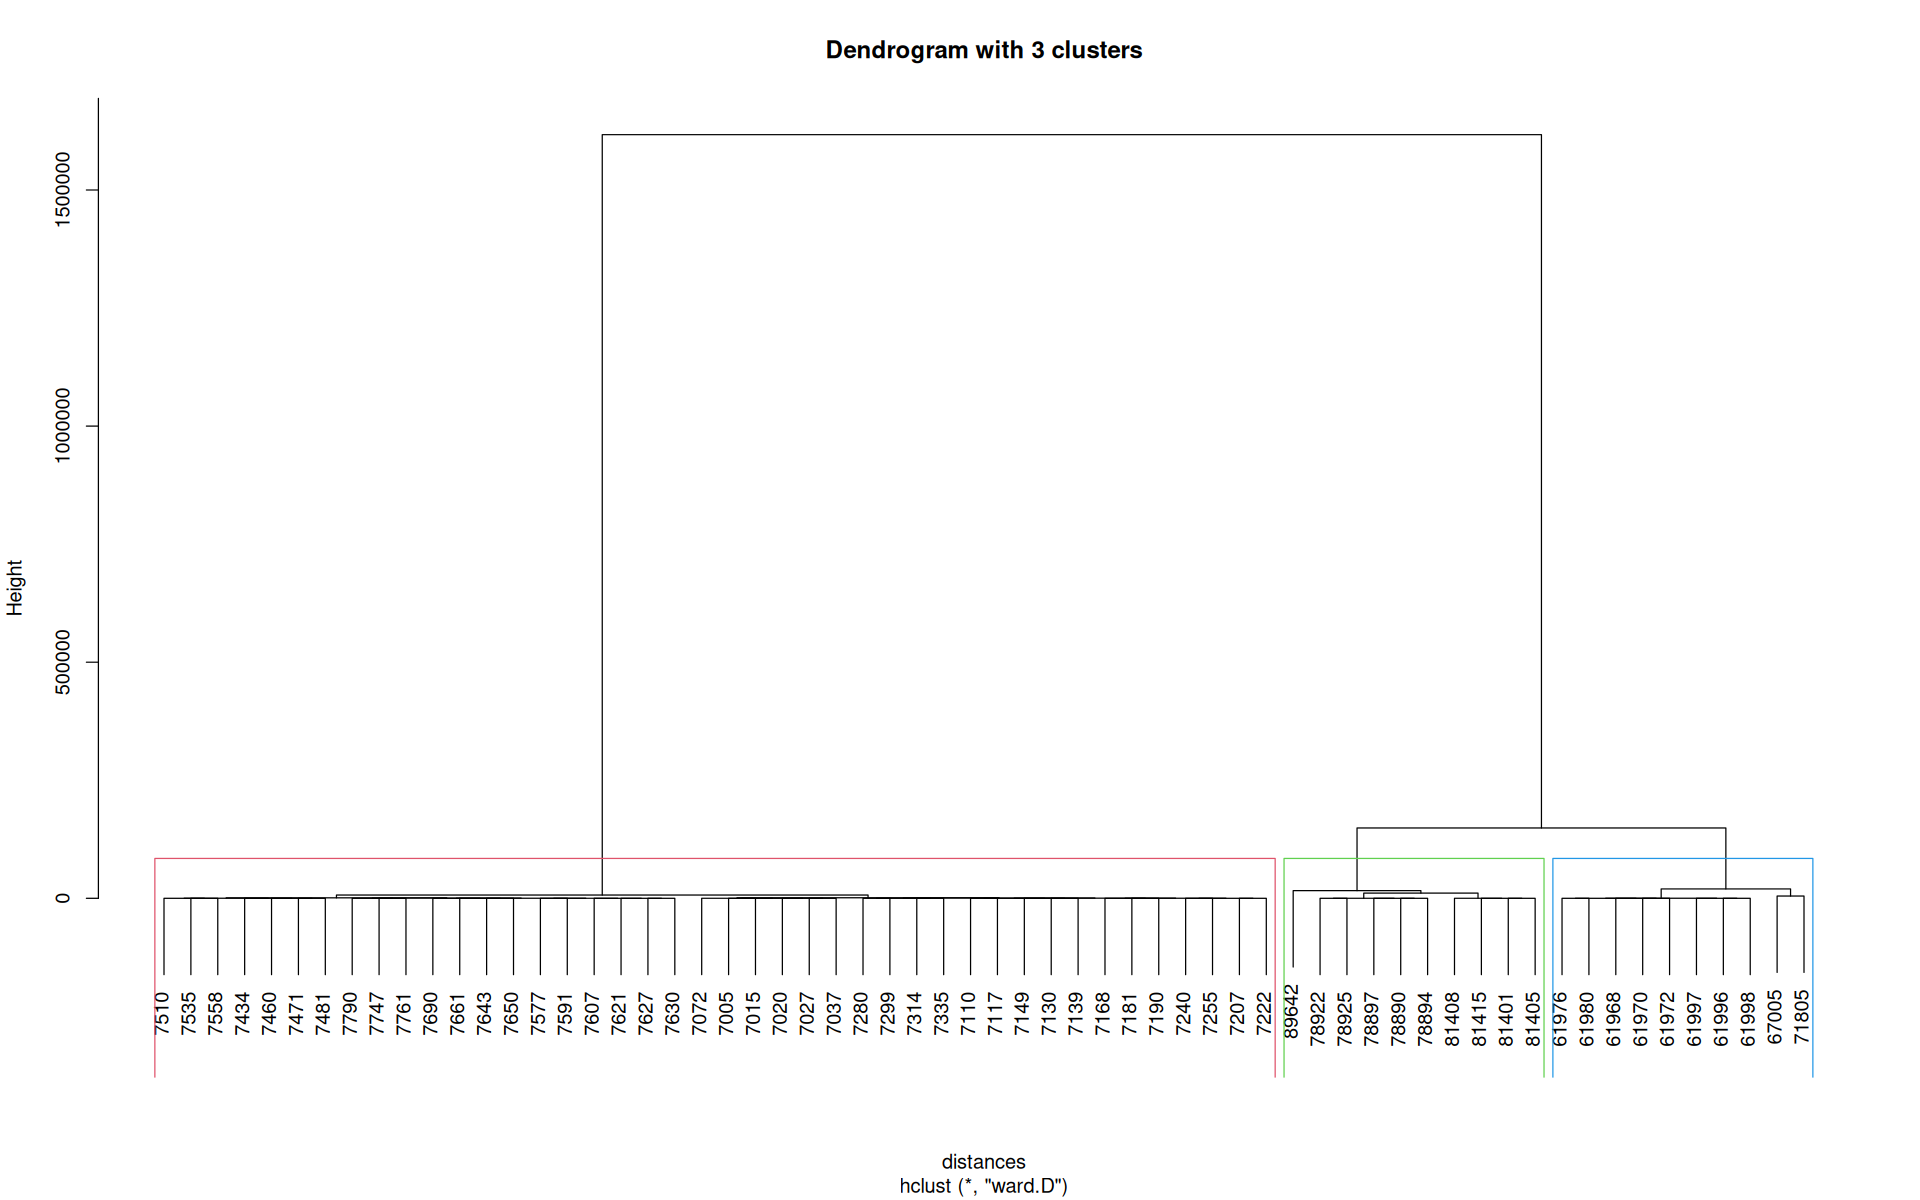

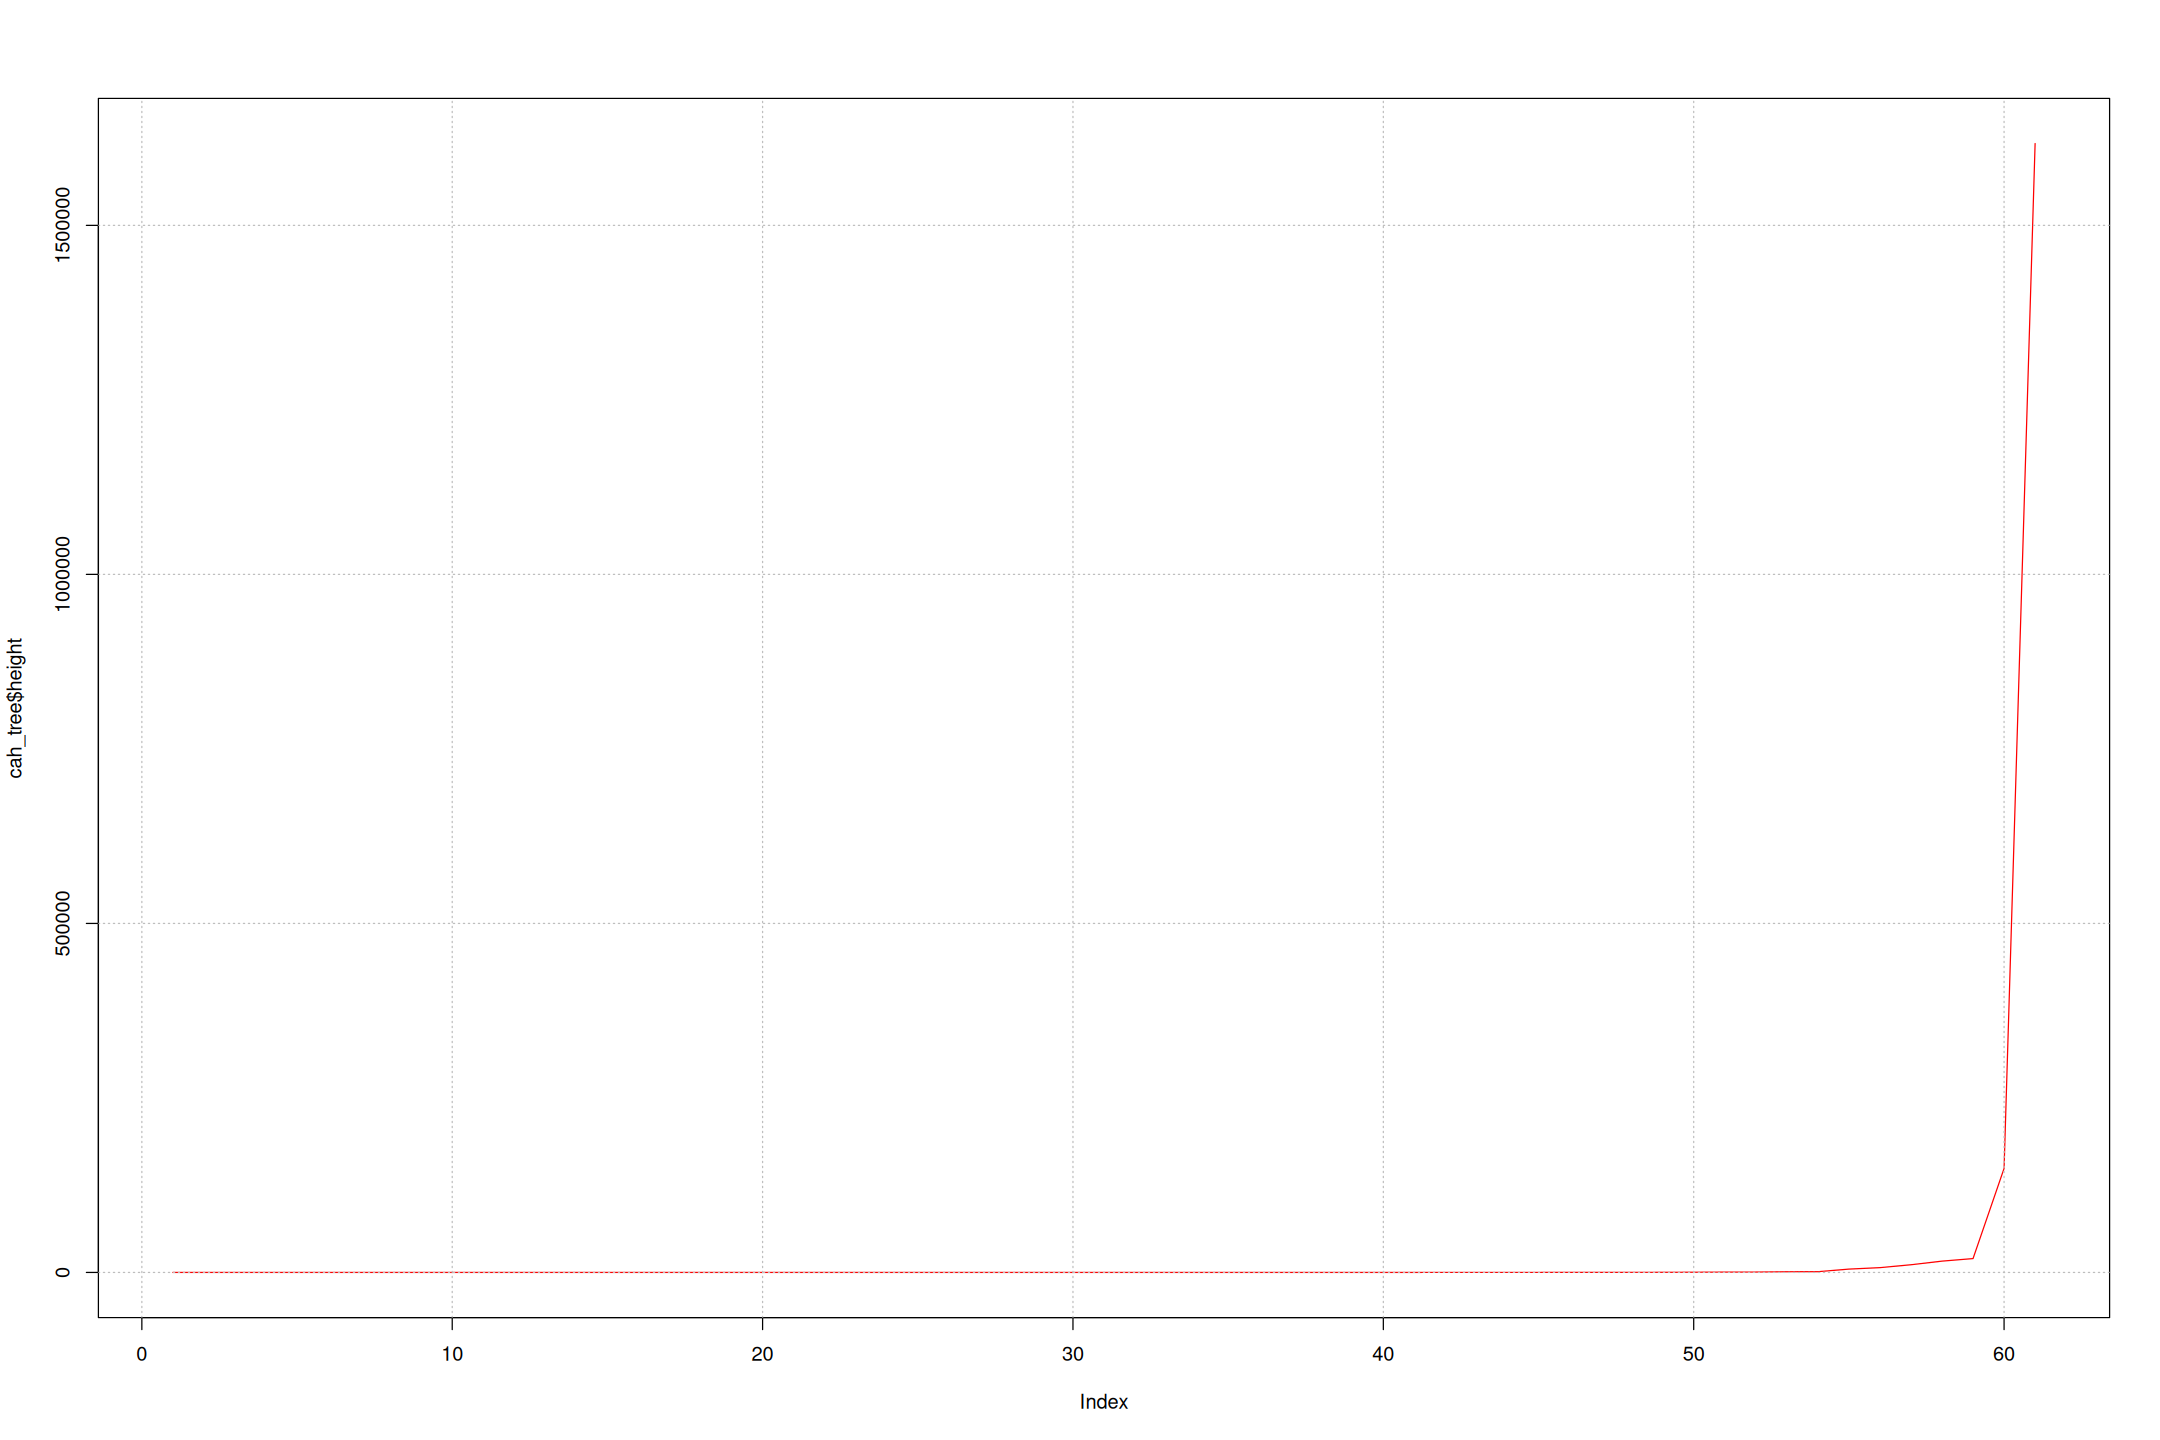

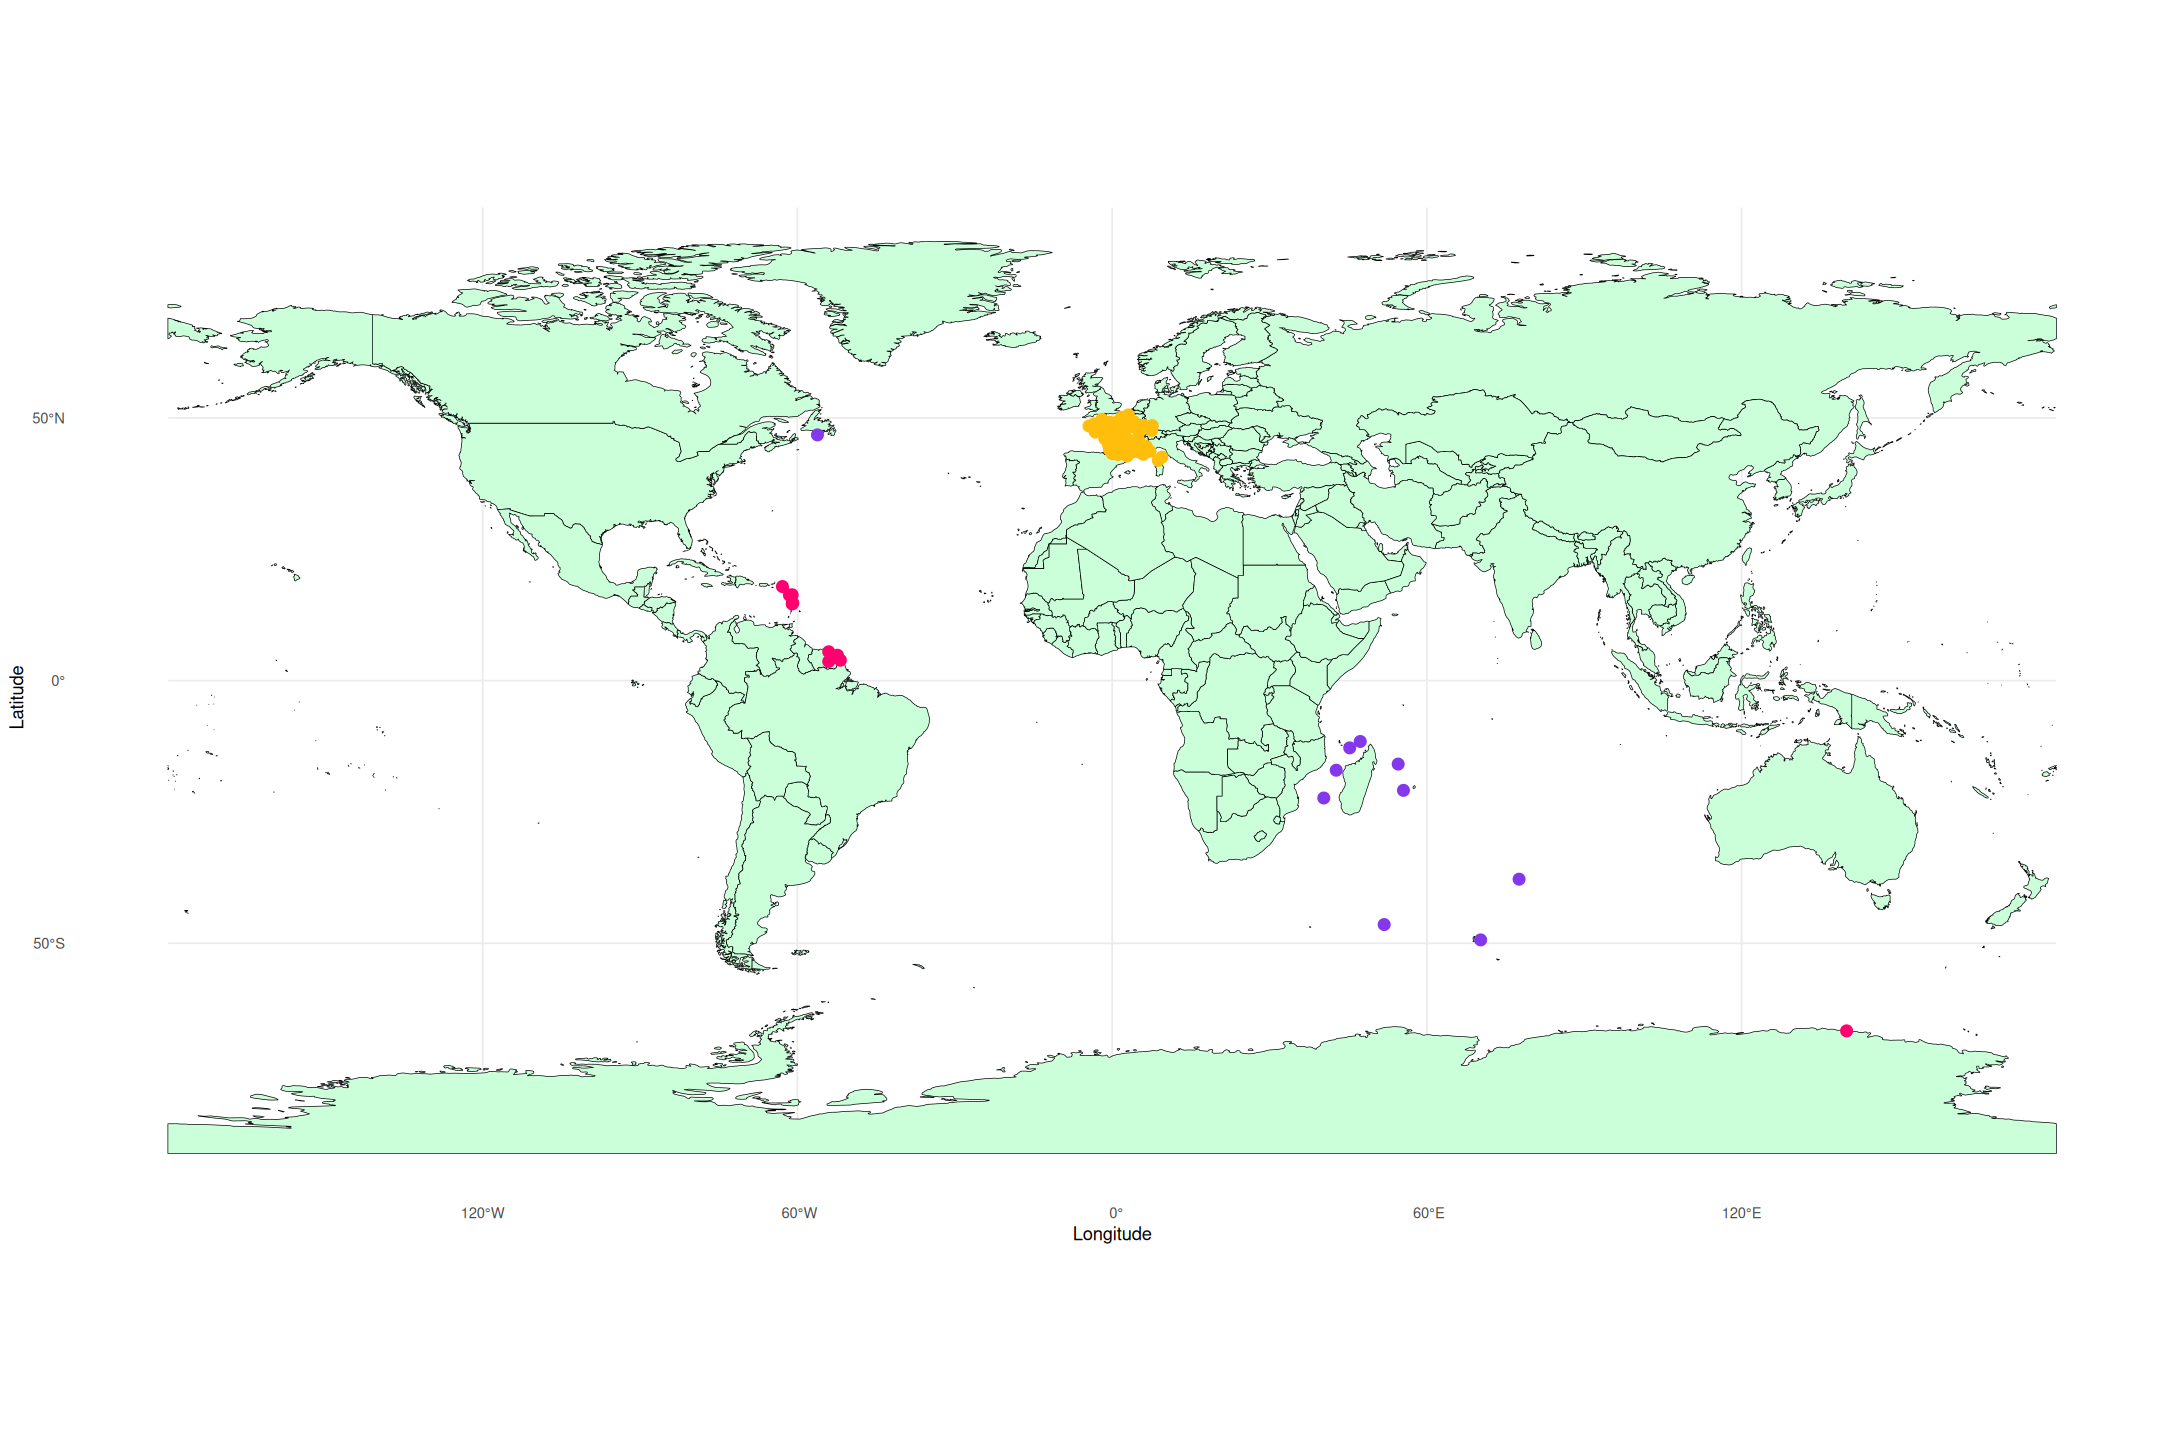

In [32]:
# display dendogram and map
auto_dendogram(temp_alltime_data, nk=3)



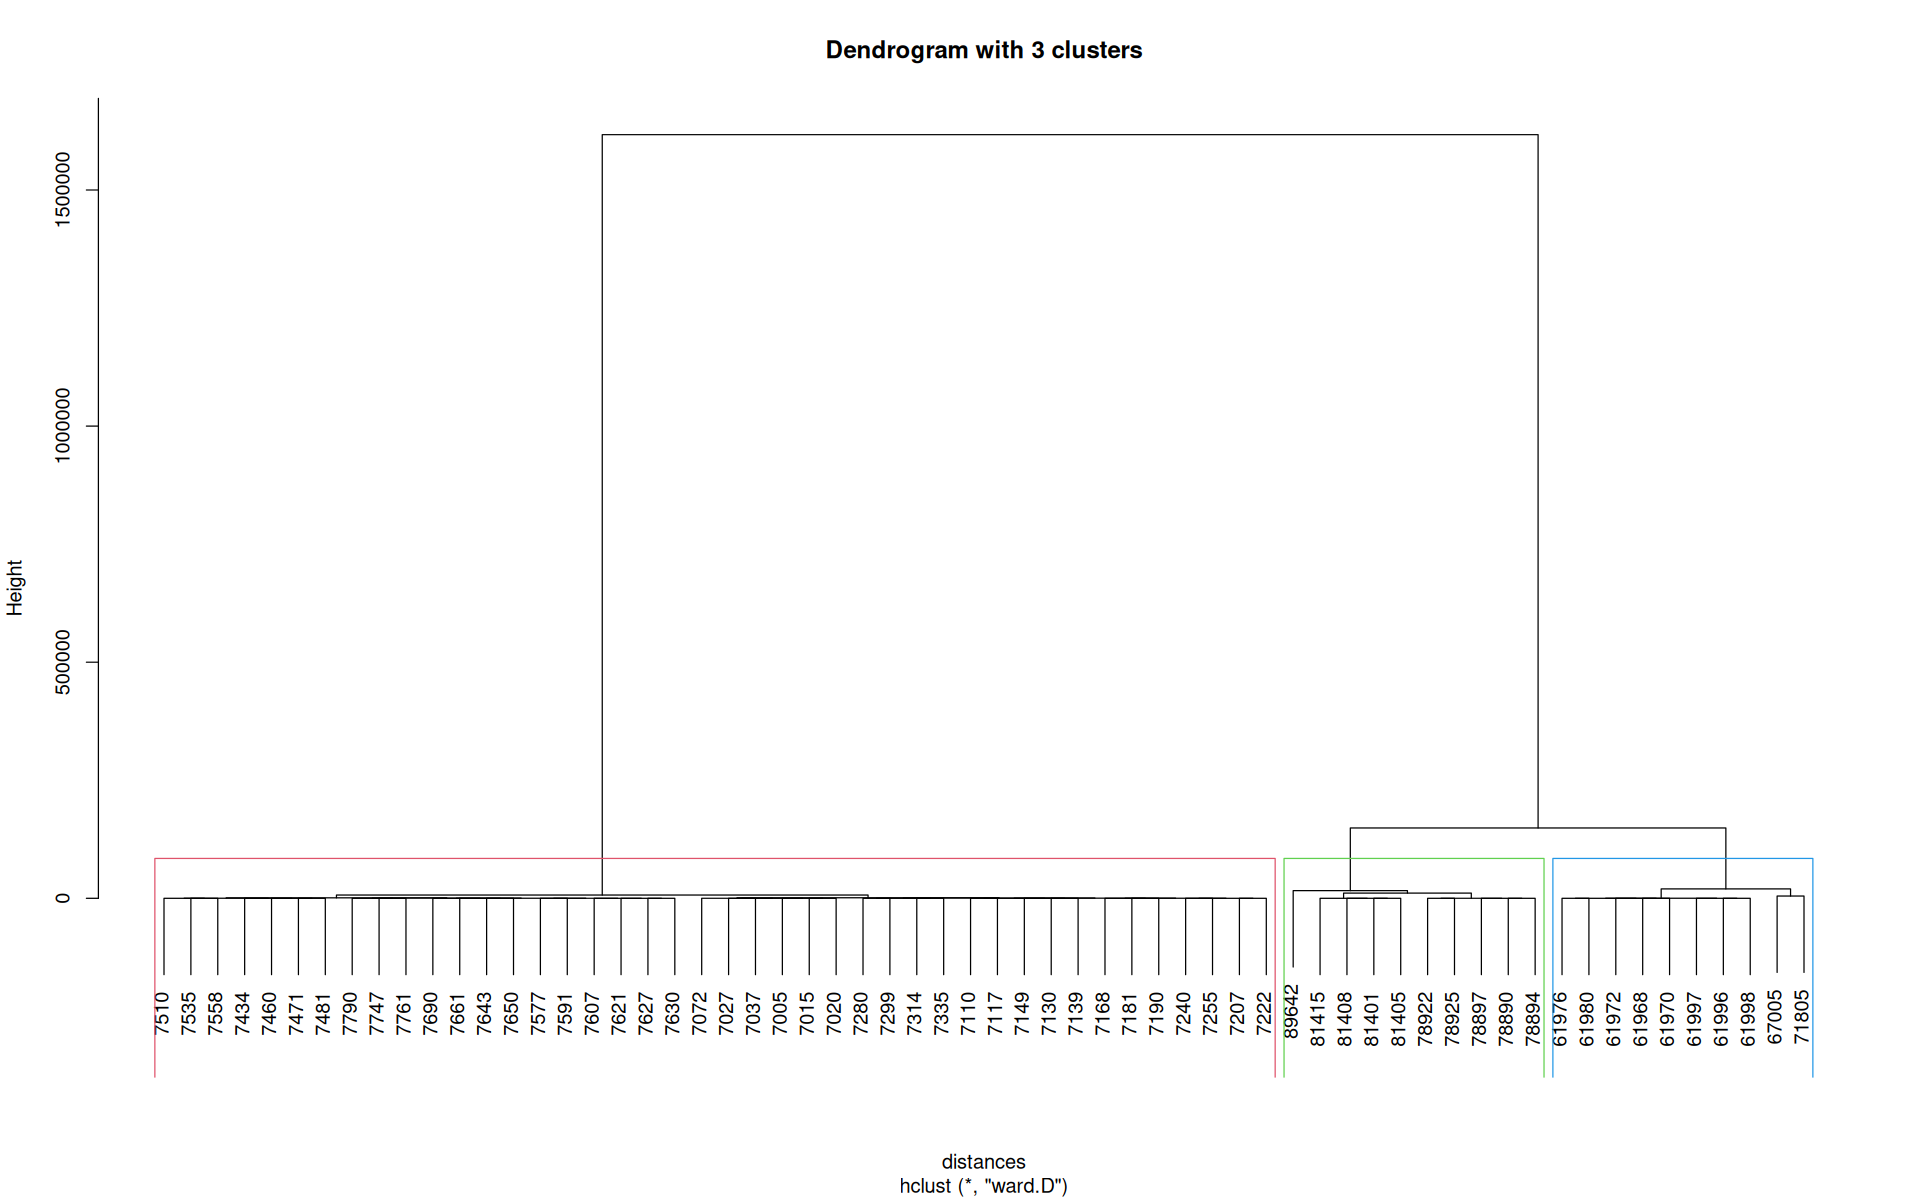

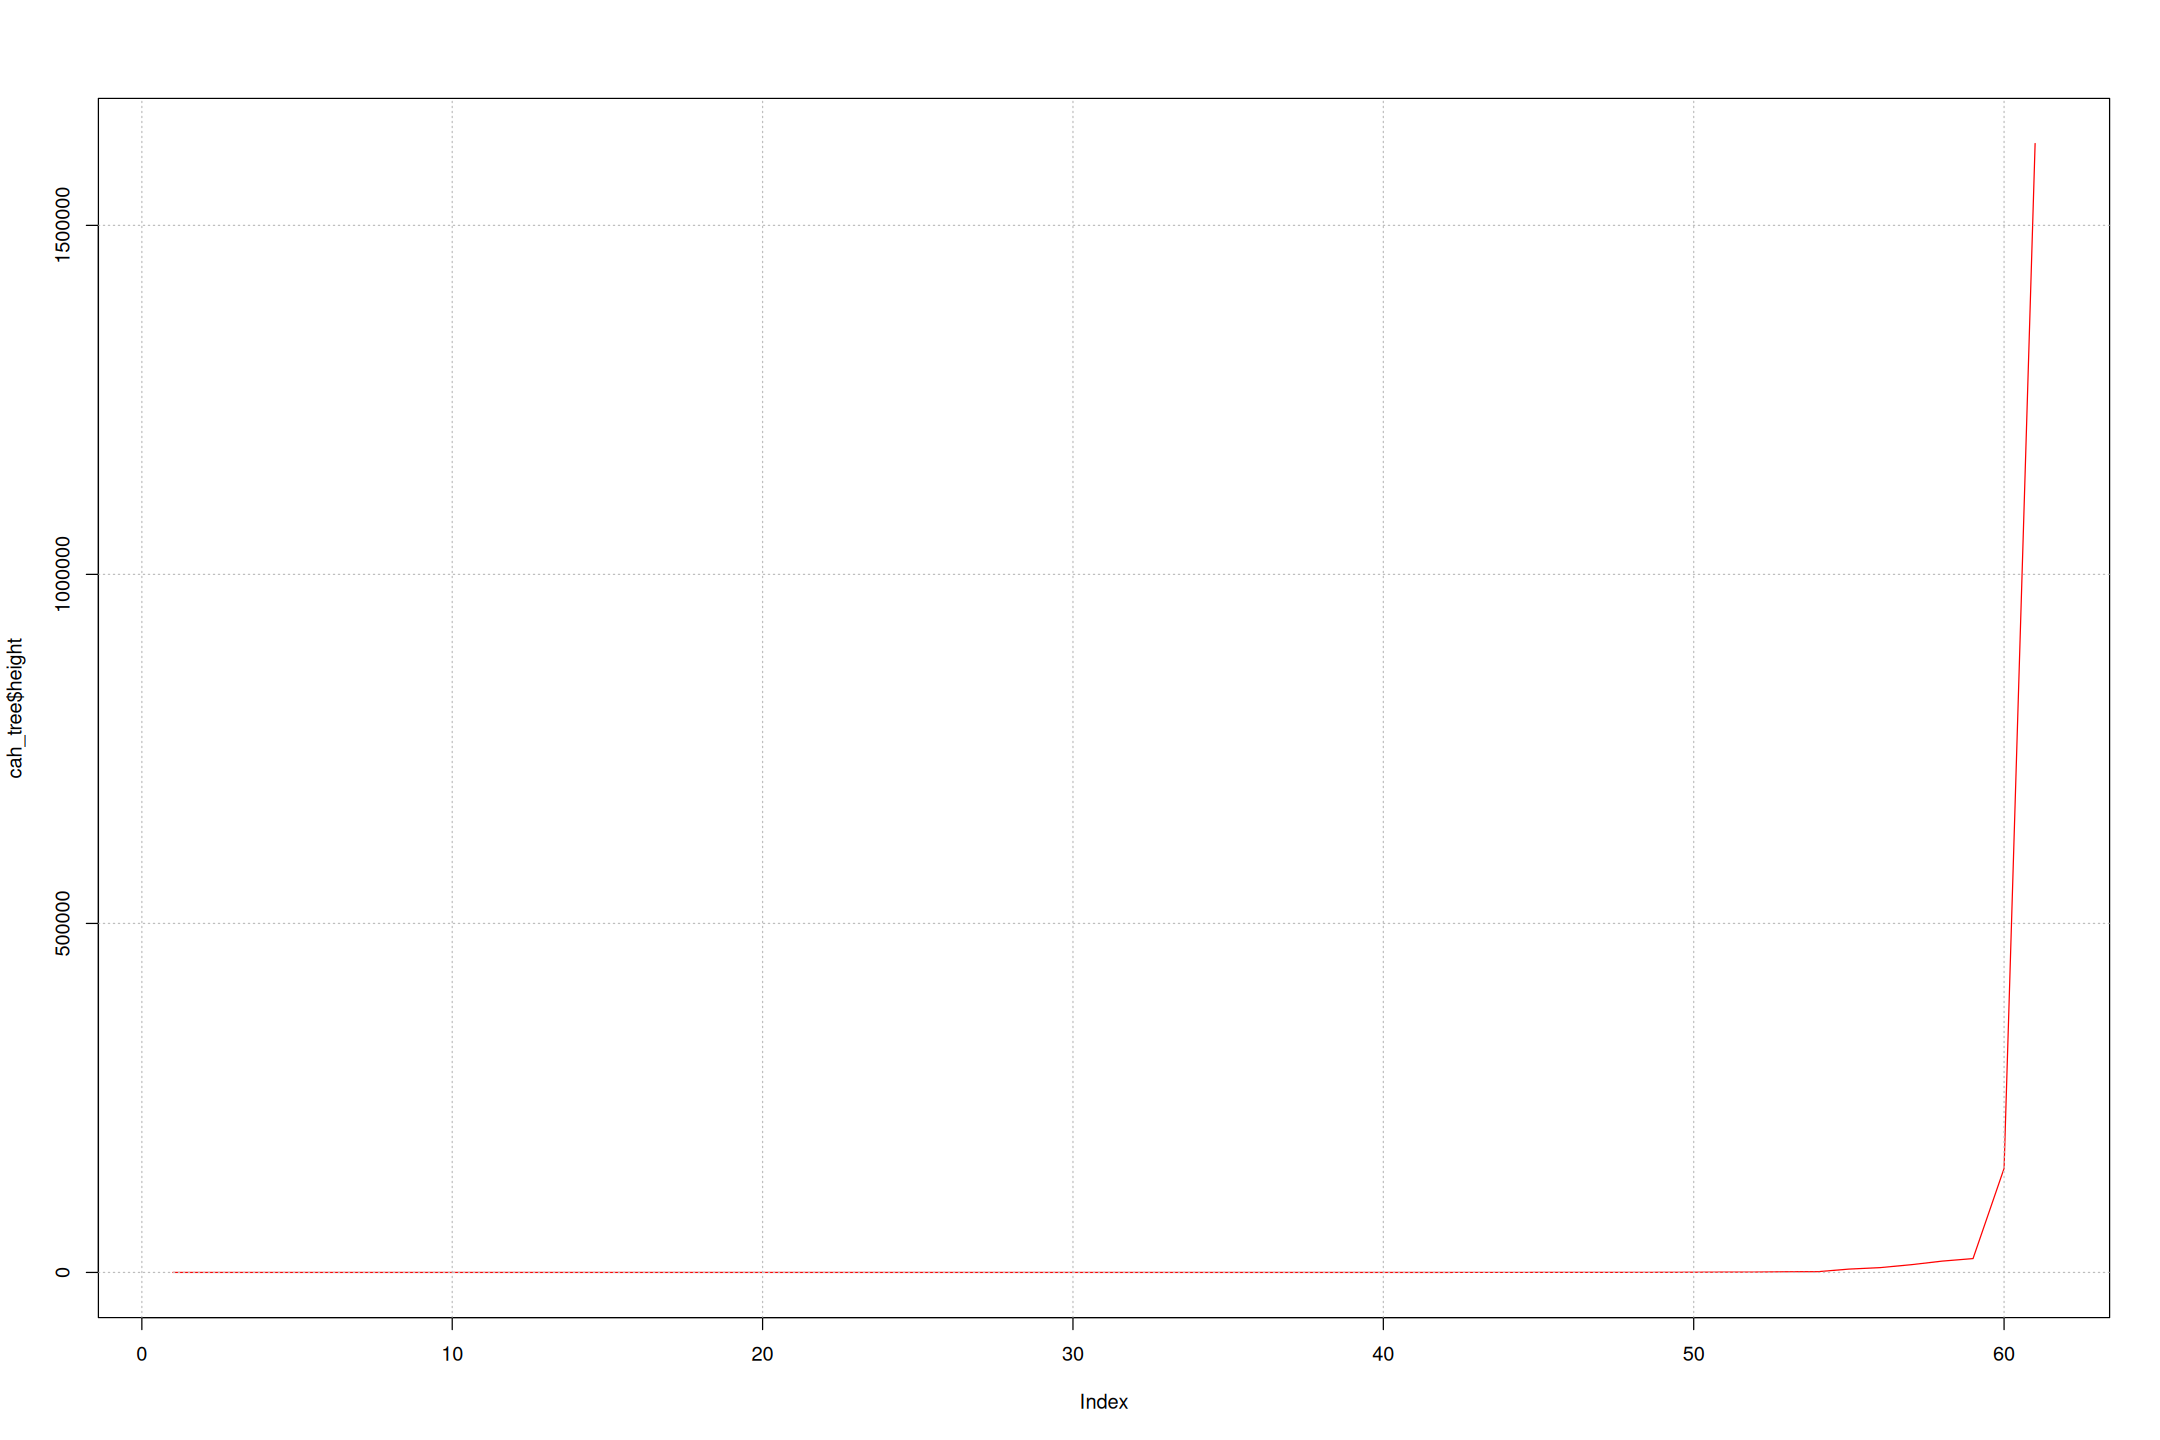

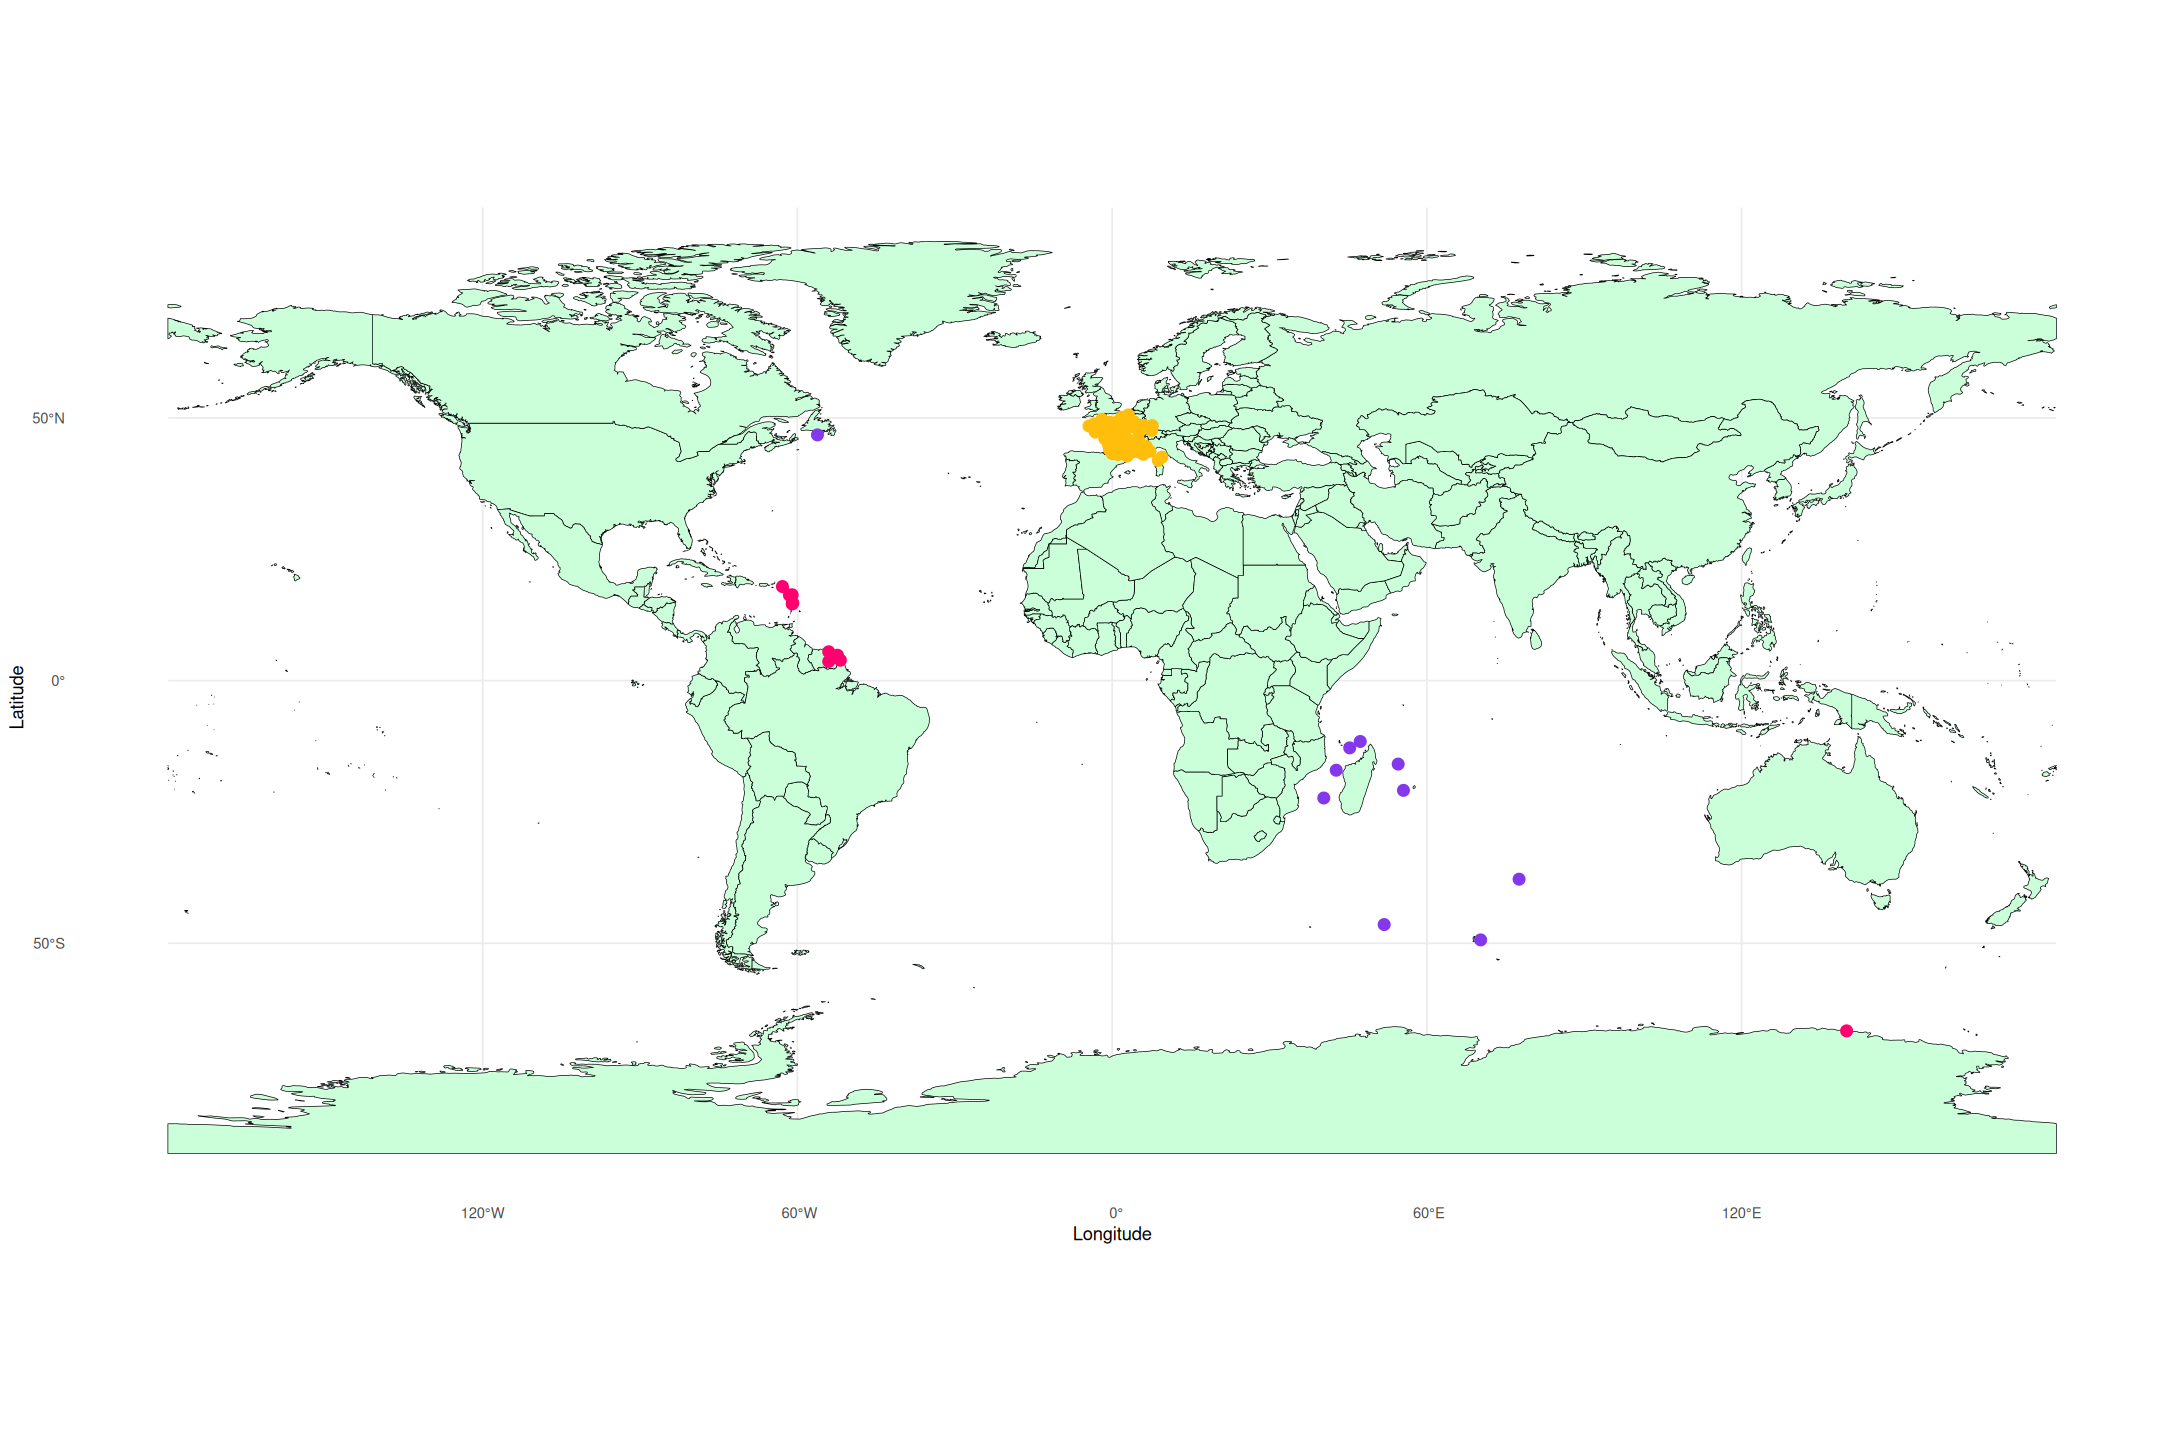

In [33]:
# display dendogram and map
auto_dendogram(temperature_monthly_avg_data, nk=3)

## Critère : Nébulosité